In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

import os
import argparse

In [2]:
# # !pip install torchviz
# !pip install graphviz


In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=1, stride=stride, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=1,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=3, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.metric = 0

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [1, 2, 2, 1])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [6]:
net = ResNet18()
net = net.to(device)
if device == 'cuda':
  net = torch.nn.DataParallel(net)
  cudnn.benchmark = True

In [7]:
# print total number of params
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Trainable params in model: ", total_params)

Trainable params in model:  4697742


In [8]:
class CutOut(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        img: Tensor image of size (C, H, W).
        """
        h = img.size(1)
        w = img.size(2)
        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask

        return img


In [9]:
import pickle
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define the transformation for the training and test sets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    CutOut(n_holes=1, length=16),  # Uncomment if CutOut is defined
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Function to unpickle the CIFAR-10 dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Custom Dataset class to load the train and val datasets
class CIFAR10Dataset(Dataset):
    def __init__(self, file, transform=None):
        data_dict = unpickle(file)
        self.data = data_dict[b'data']
        self.labels = data_dict[b'labels']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0)
        label = self.labels[idx]

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

# Paths to the CIFAR-10 dataset files
data_path = './data/cifar-10-batches-py'  # Make sure to point this to the right location of your CIFAR-10 batches
train_files = [os.path.join(data_path, 'data_batch_{}'.format(i)) for i in range(1, 6)]
val_files = os.path.join(data_path, 'test_batch')

# Creating training dataset and loader
trainset = torch.utils.data.ConcatDataset([CIFAR10Dataset(batch_file, transform=transform_train) for batch_file in train_files])
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

# Creating val dataset and loader
valset = CIFAR10Dataset(val_files, transform=transform_test)
valloader = DataLoader(valset, shuffle=False, num_workers=2)

# Loading label names
meta_data = unpickle(os.path.join(data_path, 'batches.meta'))
classes = meta_data[b'label_names']
classes = [label.decode('utf-8') for label in classes]


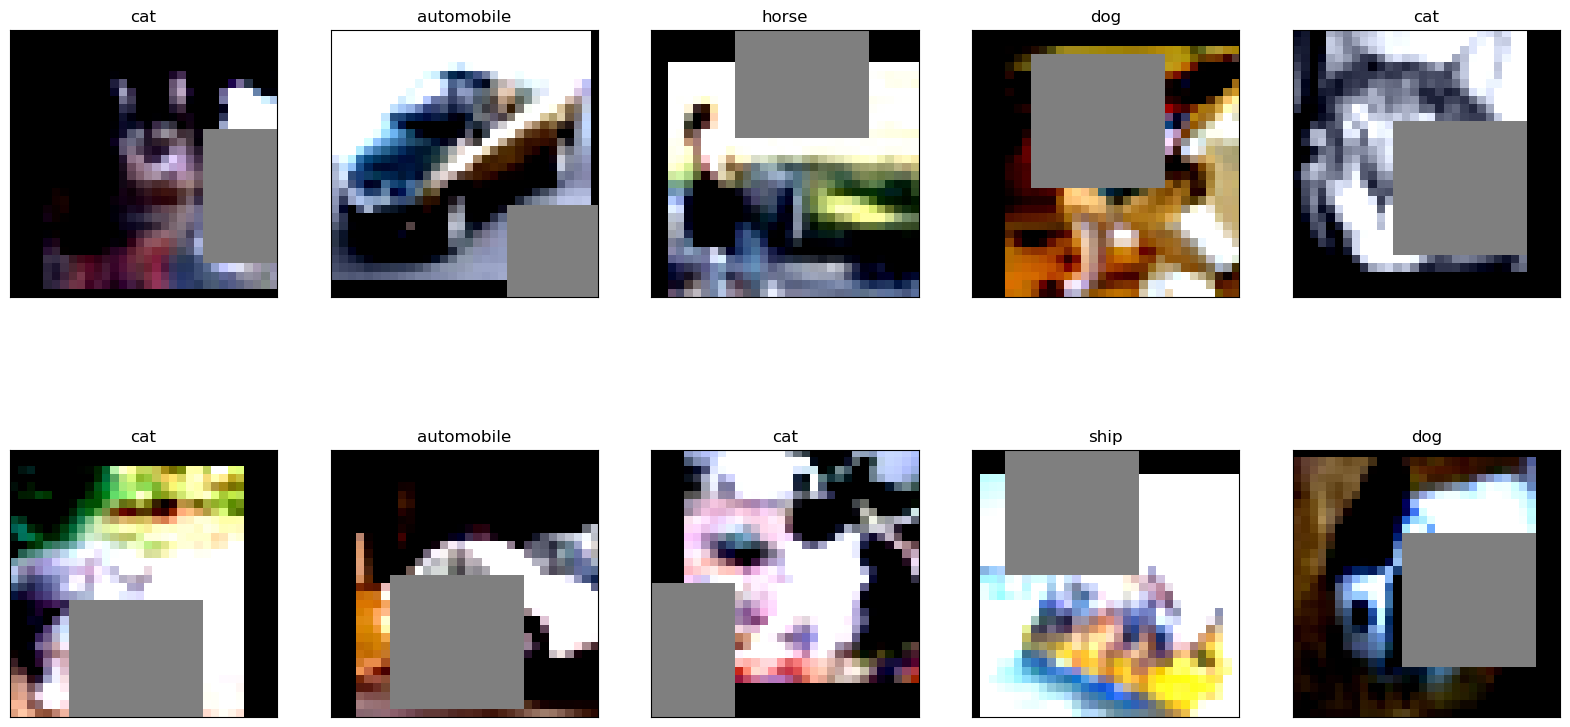

In [10]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() 
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

data_iterable = iter(trainloader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = next(data_iterable) #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(20, 10)) 

# Plotting 10 images from the train dataset
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    
    # Note: imshow cant print tensor !
    # Lets convert tensor image to numpy using im_convert function for imshow to print the image
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [11]:
from torch.optim import optimizer


def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    train_losses = []
    train_acc = []
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_losses.append(train_loss)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        train_acc.append(100.*correct/total)

    # print(len(train_acc))
    acc = np.array(train_acc).sum()/len(trainloader)
    loss = np.array(train_loss).sum()/len(trainloader)
    print("\nTrain Loss:",loss,"Train acc:",acc)
    return loss,acc

In [12]:
def val(epoch):
    global best_acc
    net.eval()
    val_loss = 0
    val_losses = []
    val_acc = []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            val_acc.append(100.*correct/total)
            val_losses.append(val_loss)
        loss = np.array(val_loss).sum()/len(valloader)
        acc = np.array(val_acc).sum()/len(valloader)
        print("\nValidation loss",loss,"Validation Acc:",acc)
    return loss,acc

In [13]:
optimizerDict = {
                    "SGD" : optim.SGD(net.parameters(), lr=0.1,
                        momentum=0.9, weight_decay=5e-4),
                    "SGDN" : optim.SGD(net.parameters(), lr=0.1,
                        momentum=0.9, nesterov = True, weight_decay=5e-4),
                    "Adam" : optim.Adam(net.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4, 
                        amsgrad=False, foreach=None, maximize=False, capturable=False),
                    "Adadelta" : optim.Adadelta(net.parameters(), lr=0.1, rho=0.9, eps=1e-08, 
                        weight_decay=5e-4, foreach=None, maximize=False),
                    "Adagrad" : optim.Adagrad(net.parameters(), lr=0.01, lr_decay=0, 
                        weight_decay=5e-4, initial_accumulator_value=0, eps=1e-08, foreach=None, maximize=False)
                }

In [14]:
import time

train_loss_history_SGD = []
train_acc_history_SGD = []
val_loss_history_SGD = []
val_acc_history_SGD = []


epoch = 0
print('==> Building model..')

early_stopping_patience = 3  # Number of epochs to wait after min has been hit
consecutive_epochs_meeting_criterion = 0  # Counter for epochs meeting the criterion
target_loss = 0.3 

optimizer = optimizerDict["SGD"]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
print("Using optimizer:","SGD")
criterion = nn.CrossEntropyLoss()
while epoch<100:
    start_time = time.time()
    epoch+=1
    train_loss,train_acc = train(epoch)
    val_loss,val_acc = val(epoch)
    train_loss_history_SGD.append(train_loss)
    train_acc_history_SGD.append(train_acc)
    val_loss_history_SGD.append(val_loss)
    val_acc_history_SGD.append(val_acc)
    
    if val_loss <= target_loss:
        consecutive_epochs_meeting_criterion += 1
        if consecutive_epochs_meeting_criterion >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch}: Validation loss reached {val_loss}% for {consecutive_epochs_meeting_criterion} consecutive epochs.")
            break  # Stop training if condition is met
    else:
        consecutive_epochs_meeting_criterion = 0
    
    
    scheduler.step(val_loss)
    end_time = time.time()  
    elapsed_time = end_time - start_time  
    print(f'Epoch {epoch} completed in {elapsed_time:.2f} seconds.')

==> Building model..
Using optimizer: SGD

Epoch: 1

Train Loss: 2.0202770802887753 Train acc: 18.942777619629073

Validation loss 1.6696150028765202 Validation Acc: 36.996283959566426
Epoch 1 completed in 62.90 seconds.

Epoch: 2

Train Loss: 1.6546474446566992 Train acc: 35.26380644052807

Validation loss 1.457580870335904 Validation Acc: 47.02756787526797
Epoch 2 completed in 62.12 seconds.

Epoch: 3

Train Loss: 1.4133283837971897 Train acc: 46.6980023706507

Validation loss 1.4202596082048091 Validation Acc: 51.9840813677041
Epoch 3 completed in 62.35 seconds.

Epoch: 4

Train Loss: 1.2764022688948033 Train acc: 53.92220605527725

Validation loss 1.5334374219096076 Validation Acc: 48.996834122481
Epoch 4 completed in 61.99 seconds.

Epoch: 5

Train Loss: 1.1904145873897136 Train acc: 57.078494474392365

Validation loss 1.4174738315470583 Validation Acc: 53.41938995535228
Epoch 5 completed in 62.44 seconds.

Epoch: 6

Train Loss: 1.140011745656978 Train acc: 59.12737551147842

Vali

In [18]:
early_stopping_patience = 3  # Number of epochs to wait after min has been hit
consecutive_epochs_meeting_criterion = 0  # Counter for epochs meeting the criterion
target_loss = 0.1 

optimizer = optimizerDict["SGD"]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
print("Using optimizer:","SGD")
criterion = nn.CrossEntropyLoss()
while epoch<100:
    start_time = time.time()
    epoch+=1
    train_loss,train_acc = train(epoch)
    val_loss,val_acc = val(epoch)
    train_loss_history_SGD.append(train_loss)
    train_acc_history_SGD.append(train_acc)
    val_loss_history_SGD.append(val_loss)
    val_acc_history_SGD.append(val_acc)
    
    if val_loss <= target_loss:
        consecutive_epochs_meeting_criterion += 1
        if consecutive_epochs_meeting_criterion >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch}: Validation loss reached {val_loss}% for {consecutive_epochs_meeting_criterion} consecutive epochs.")
            break  # Stop training if condition is met
    else:
        consecutive_epochs_meeting_criterion = 0
    
    
    scheduler.step(val_loss)
    end_time = time.time()  
    elapsed_time = end_time - start_time  
    print(f'Epoch {epoch} completed in {elapsed_time:.2f} seconds.')

Using optimizer: SGD

Epoch: 62

Train Loss: 0.24300574813030962 Train acc: 91.37045599538078

Validation loss 0.21033540503148979 Validation Acc: 92.8621271323814
Epoch 62 completed in 62.41 seconds.

Epoch: 63

Train Loss: 0.23764506127906967 Train acc: 91.74814370350926

Validation loss 0.2074724667334574 Validation Acc: 93.20477233009545
Epoch 63 completed in 62.15 seconds.

Epoch: 64

Train Loss: 0.2301714086317608 Train acc: 92.10266256068412

Validation loss 0.20579026666088843 Validation Acc: 93.05794844069668
Epoch 64 completed in 62.50 seconds.

Epoch: 65

Train Loss: 0.21993509310900078 Train acc: 92.4414491112548

Validation loss 0.2031683468508039 Validation Acc: 93.24134334466366
Epoch 65 completed in 62.48 seconds.

Epoch: 66

Train Loss: 0.21812416994568826 Train acc: 92.83039838512181

Validation loss 0.20343238271874242 Validation Acc: 93.37517242133961
Epoch 66 completed in 62.17 seconds.

Epoch: 67

Train Loss: 0.21117308264168042 Train acc: 92.63967321444072

Valid

KeyboardInterrupt: 

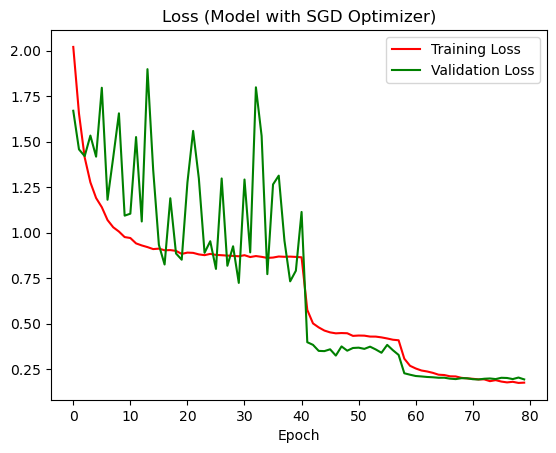

In [19]:
plt.plot(train_loss_history_SGD, 'r', label='Training Loss')
plt.plot(val_loss_history_SGD,  'g',  label='Validation Loss')
plt.xlabel("Epoch")
plt.title("Loss (Model with SGD Optimizer)")
plt.legend()

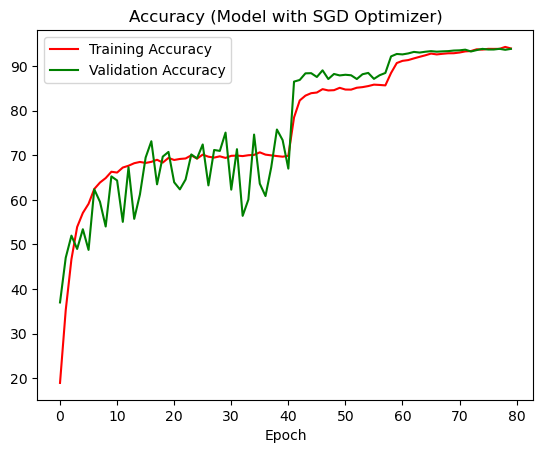

In [20]:
plt.plot(train_acc_history_SGD, 'r', label='Training Accuracy')
plt.plot(val_acc_history_SGD,  'g',  label='Validation Accuracy')
plt.xlabel("Epoch")
plt.title("Accuracy (Model with SGD Optimizer)")
plt.legend()

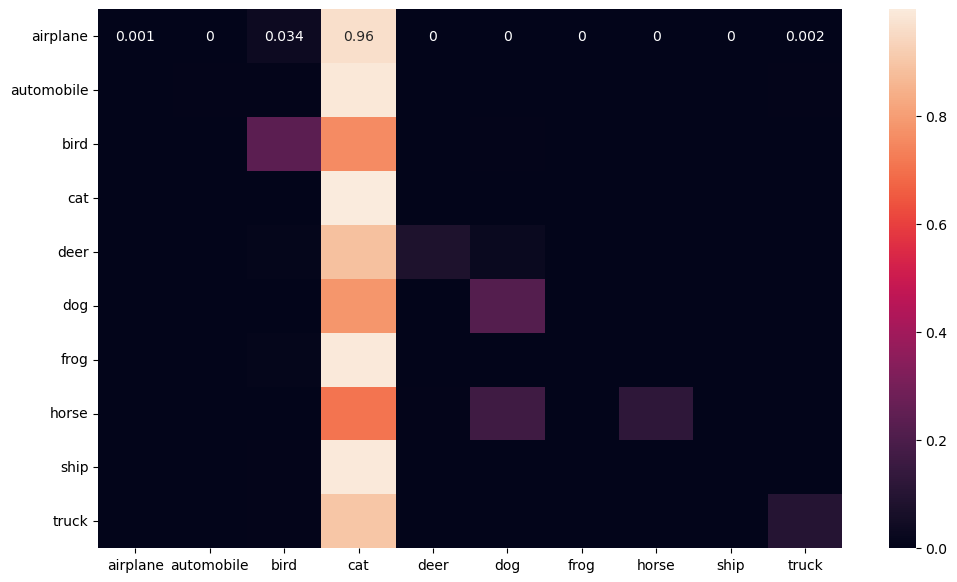

In [21]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(valloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        _, pred = outputs.max(1)
        y_pred.extend(pred.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('ConfusionMatrix(SGD).png')

In [ ]:
import matplotlib.pyplot as plt

def plot_optimizer_accuracy(accuracy, label):
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, marker='o', linestyle='-', label=label)
    
plt.figure(figsize=(12, 8))

# Plotting the data for each optimizer
plot_optimizer_accuracy(val_acc_history_Adam, 'Adam Optimizer')
plot_optimizer_accuracy(val_acc_history_Adadelta, 'Adadelta Optimizer')
plot_optimizer_accuracy(val_acc_history_SGDN, 'SGDN Optimizer')
plot_optimizer_accuracy(val_acc_history_SGD, 'SGD Optimizer')
plot_optimizer_accuracy(val_acc_history_Adagrad, 'Adagrad Optimizer')

plt.title('Validation Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('validation_accuracy_vs_epochs.png', dpi=300)


In [23]:
class CustomTestDataset(Dataset):
    def __init__(self, file, transform=None):
        data_dict = unpickle(file)
        self.data = data_dict[b'data']
        self.ids = data_dict[b'ids']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0)
        id = self.ids[idx]

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, id

In [25]:
testset = CustomTestDataset('/scratch/aup2007/project/dl_data/cifar_test_nolabels.pkl', transform=transform_test)
testloader = DataLoader(testset, shuffle=False, num_workers=2)

In [26]:
import csv

net.eval()
with open('final.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Labels']) 

    with torch.no_grad():  
        for i, (inputs, ids) in enumerate(testloader):
            inputs = inputs.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)

            for id, pred in zip(ids, predicted):
                writer.writerow([id.item(), pred.item()])  

print("CSV file created: 'final.csv'")

CSV file created: 'final.csv'
